# Exploratory Data Analysis for Tomato Leaf Disease Detection

This notebook performs exploratory data analysis on the tomato leaf disease dataset to understand its characteristics and distribution.

## Setup and Configuration

### Library Imports
I am using the following libraries:
- `numpy` : For data manipulation and analysis
- `matplotlib` & `seaborn`: For data visualization
- `cv2`: For image processing
- `pathlib`: For handling file paths

### Class Definitions

The dataset contains 7 classes of tomato leaf conditions:
1. Bacterial Spot (Red)
2. Early Blight (Green)
3. Healthy (Blue)
4. Late Blight (Gold)
5. Leaf Mold (Hot Pink)
6. Target Spot (Indigo)
7. Black Spot (Maroon)

Each class is assigned a unique color for consistent visualization throughout the analysis. This color coding helps in:
- Distinguishing between different classes in plots
- Maintaining visual consistency across different visualizations
- Making the analysis more intuitive and readable

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path

plt.style.use('seaborn')

# Class names
CLASS_NAMES = {
    0: 'Bacterial Spot',
    1: 'Early Blight',
    2: 'Healthy',
    3: 'Late Blight',
    4: 'Leaf Mold',
    5: 'Target Spot',
    6: 'Black Spot'
}

# Define colors for each class for consistent visualization
CLASS_COLORS = {
    0: '#FF0000',
    1: '#00FF00',
    2: '#0000FF',
    3: '#FFD700',
    4: '#FF69B4',
    5: '#4B0082',
    6: '#800000'
}

DATASET_PATH = Path("tomato-leaf-diseases")

## Dataset Distribution Analysis

This section analyzes the distribution of classes across different dataset splits (train, validation, and test) to ensure balanced representation.

### Visualization Components

Overall Class Distribution

- Bar chart showing the total number of instances per class
    - Percentage labels for each class
    - Helps identify any class imbalance issues
    - Split-wise Distribution

- Grouped bar chart comparing class distributions across splits
    - Helps verify proper stratification of data
    - Ensures balanced representation in train/valid/test sets

- Analysis Metrics
    - Total number of annotations
    - Per-class instance counts
    - Percentage distribution of classes
    - Split-wise distribution analysis

## Key Points Being Observed

Class Balance:

> Are classes evenly distributed?
Answer: No, the classes are not balanced. Early bright class takes up nearly 50% of the anotations.

> What are the chances of model overfitting?
Answer: Highly likely, given the skewness of the dataset

> Expect poor performance in classes that don't have a lot of annotations

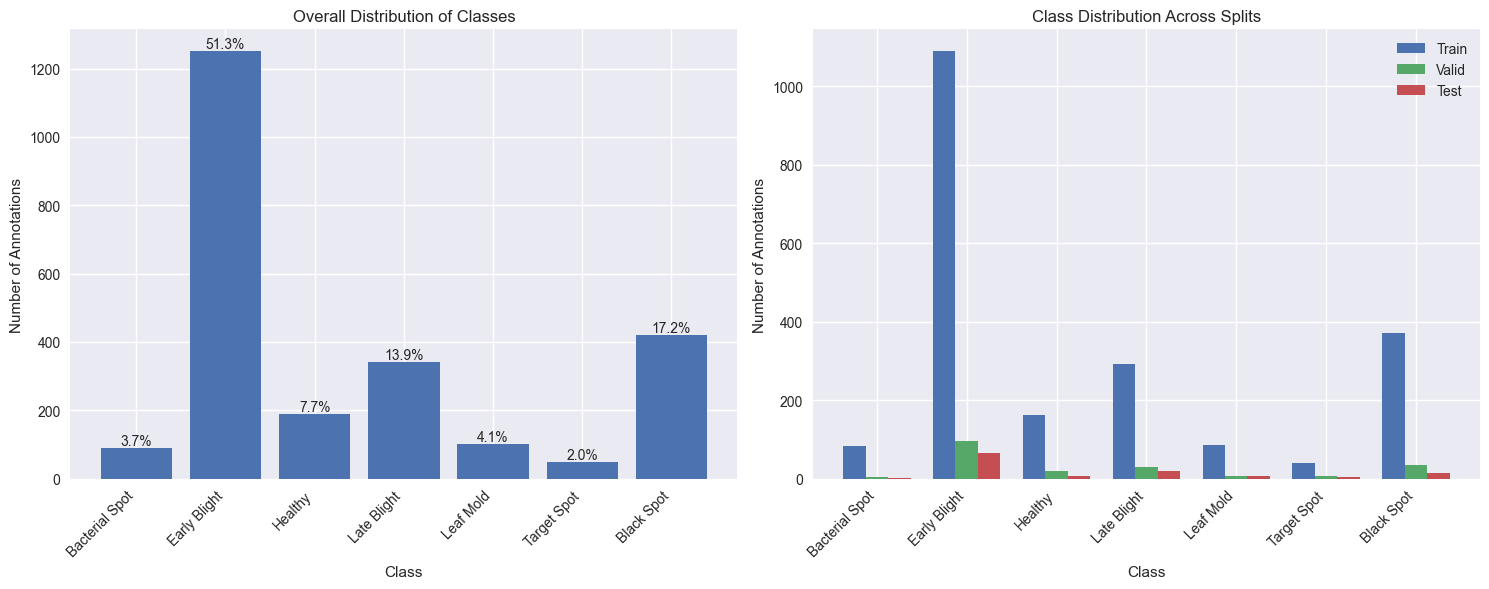


Class Distribution Summary:
--------------------------------------------------
Bacterial Spot: 90 instances (3.7%)
Early Blight: 1252 instances (51.3%)
Healthy: 188 instances (7.7%)
Late Blight: 340 instances (13.9%)
Leaf Mold: 100 instances (4.1%)
Target Spot: 49 instances (2.0%)
Black Spot: 420 instances (17.2%)
--------------------------------------------------
Total annotations: 2439


In [2]:
# Analysis of class distribution
def analyze_class_distribution(DATASET_PATH):
    """
    Analyzes the distribution of classes in the dataset across different splits.
    
    Args:
        DATASET_PATH: Path to the dataset root directory
        
    Returns:
        class_counts: Overall count for each class
        split_counts: Count for each class in each split
        total_annotations: Total number of annotations
    """
    class_counts = {i: 0 for i in range(len(CLASS_NAMES))}
    split_counts = {split: {i: 0 for i in range(len(CLASS_NAMES))} 
                   for split in ['train', 'valid', 'test']}
    total_annotations = 0
    
    # Process train, valid, test folders
    for split in ['train', 'valid', 'test']:
        labels_path = DATASET_PATH / split / 'labels'
        if not labels_path.exists():
            continue
            
        for label_file in labels_path.glob('*.txt'):
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    split_counts[split][class_id] += 1
                    total_annotations += 1
    
    return class_counts, split_counts, total_annotations

class_counts, split_counts, total_annotations = analyze_class_distribution(DATASET_PATH)

# Plot overall class distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
classes = list(CLASS_NAMES.values())
counts = [class_counts[i] for i in range(len(CLASS_NAMES))]

bars = plt.bar(classes, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Overall Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Annotations')

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_annotations) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom')

# Plot distribution across splits
plt.subplot(1, 2, 2)
x = np.arange(len(CLASS_NAMES))
width = 0.25

for i, split in enumerate(['train', 'valid', 'test']):
    counts = [split_counts[split][j] for j in range(len(CLASS_NAMES))]
    plt.bar(x + i*width, counts, width, label=split.capitalize())

plt.xlabel('Class')
plt.ylabel('Number of Annotations')
plt.title('Class Distribution Across Splits')
plt.xticks(x + width, classes, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nClass Distribution Summary:")
print("-" * 50)
for class_id, count in class_counts.items():
    percentage = (count / total_annotations) * 100
    print(f"{CLASS_NAMES[class_id]}: {count} instances ({percentage:.1f}%)")
print("-" * 50)
print(f"Total annotations: {total_annotations}")

# Image Visualization and Annotation Analysis

## Overview
This section focuses on visualizing the tomato leaf disease dataset images along with their corresponding bounding box annotations. The visualizations help u in understanding the data quality, annotation consistency, and detection challenges.

## YOLO Format Annotations
The dataset uses YOLO format annotations:
- Normalized coordinates (0-1 range)
- Center-based positioning
- Class IDs matching the disease categories
- Box dimensions as width and height

## Visualization Components

### 1. Image Chracteristics
- RGB color space conversion

### 2. Bounding Box Display
- Color-coded boxes by disease class
- Clear label positioning
- Appropriate box sizing
- High visibility on various backgrounds

### 3. Label Visualization
- Disease name display
- Color-matched to bounding boxes

## Purpose and Benefits
These visualizations serve multiple purposes:
1. Dataset Validation
   - Verify annotation locations (often due to scaling, they might be in wrong places)
   - Check label consistency
   - Identify potential errors

2. Understanding Disease Presentation
   - Visual patterns of each disease (size, location)
   - Typical affected areas
   - Disease co-occurrence

3. Training Preparation
   - Assess annotation quality
   - Identify challenging cases
   - Guide model development

In [3]:
def load_yolo_image_with_boxes(image_path, label_path):
    """
    Load image and its corresponding YOLO annotations
    
    Args:
        image_path (str): Path to image
        label_path (str): Path to YOLO format label file
    Returns:
        image: numpy array of image
        boxes: list of [class_id, x, y, w, h]
    """
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([int(class_id), x, y, w, h])
    
    return image, boxes

def plot_image_with_boxes(image, boxes, title=None):
    """
    Plot image with bounding boxes
    
    Args:
        image: numpy array of image
        boxes: list of [class_id, x, y, w, h] in YOLO format
        title: optional title for the plot
    """
    img_h, img_w = image.shape[:2]
    
    plt.imshow(image)
    
    for box in boxes:
        class_id, x, y, w, h = box
        
        # Convert YOLO format to pixel coordinates
        x_center = int(x * img_w)
        y_center = int(y * img_h)
        width = int(w * img_w)
        height = int(h * img_h)
        
        # Calculate box corners
        x1 = x_center - width//2
        y1 = y_center - height//2
        x2 = x_center + width//2
        y2 = y_center + height//2
        
        # Plot box
        rect = plt.Rectangle((x1, y1), width, height,
                           fill=False, color=CLASS_COLORS[class_id], linewidth=2)
        plt.gca().add_patch(rect)
        
        # Add label
        plt.text(x1, y1-5, CLASS_NAMES[class_id], 
                color=CLASS_COLORS[class_id], fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.7))
    
    if title:
        plt.title(title)
    plt.axis('off')

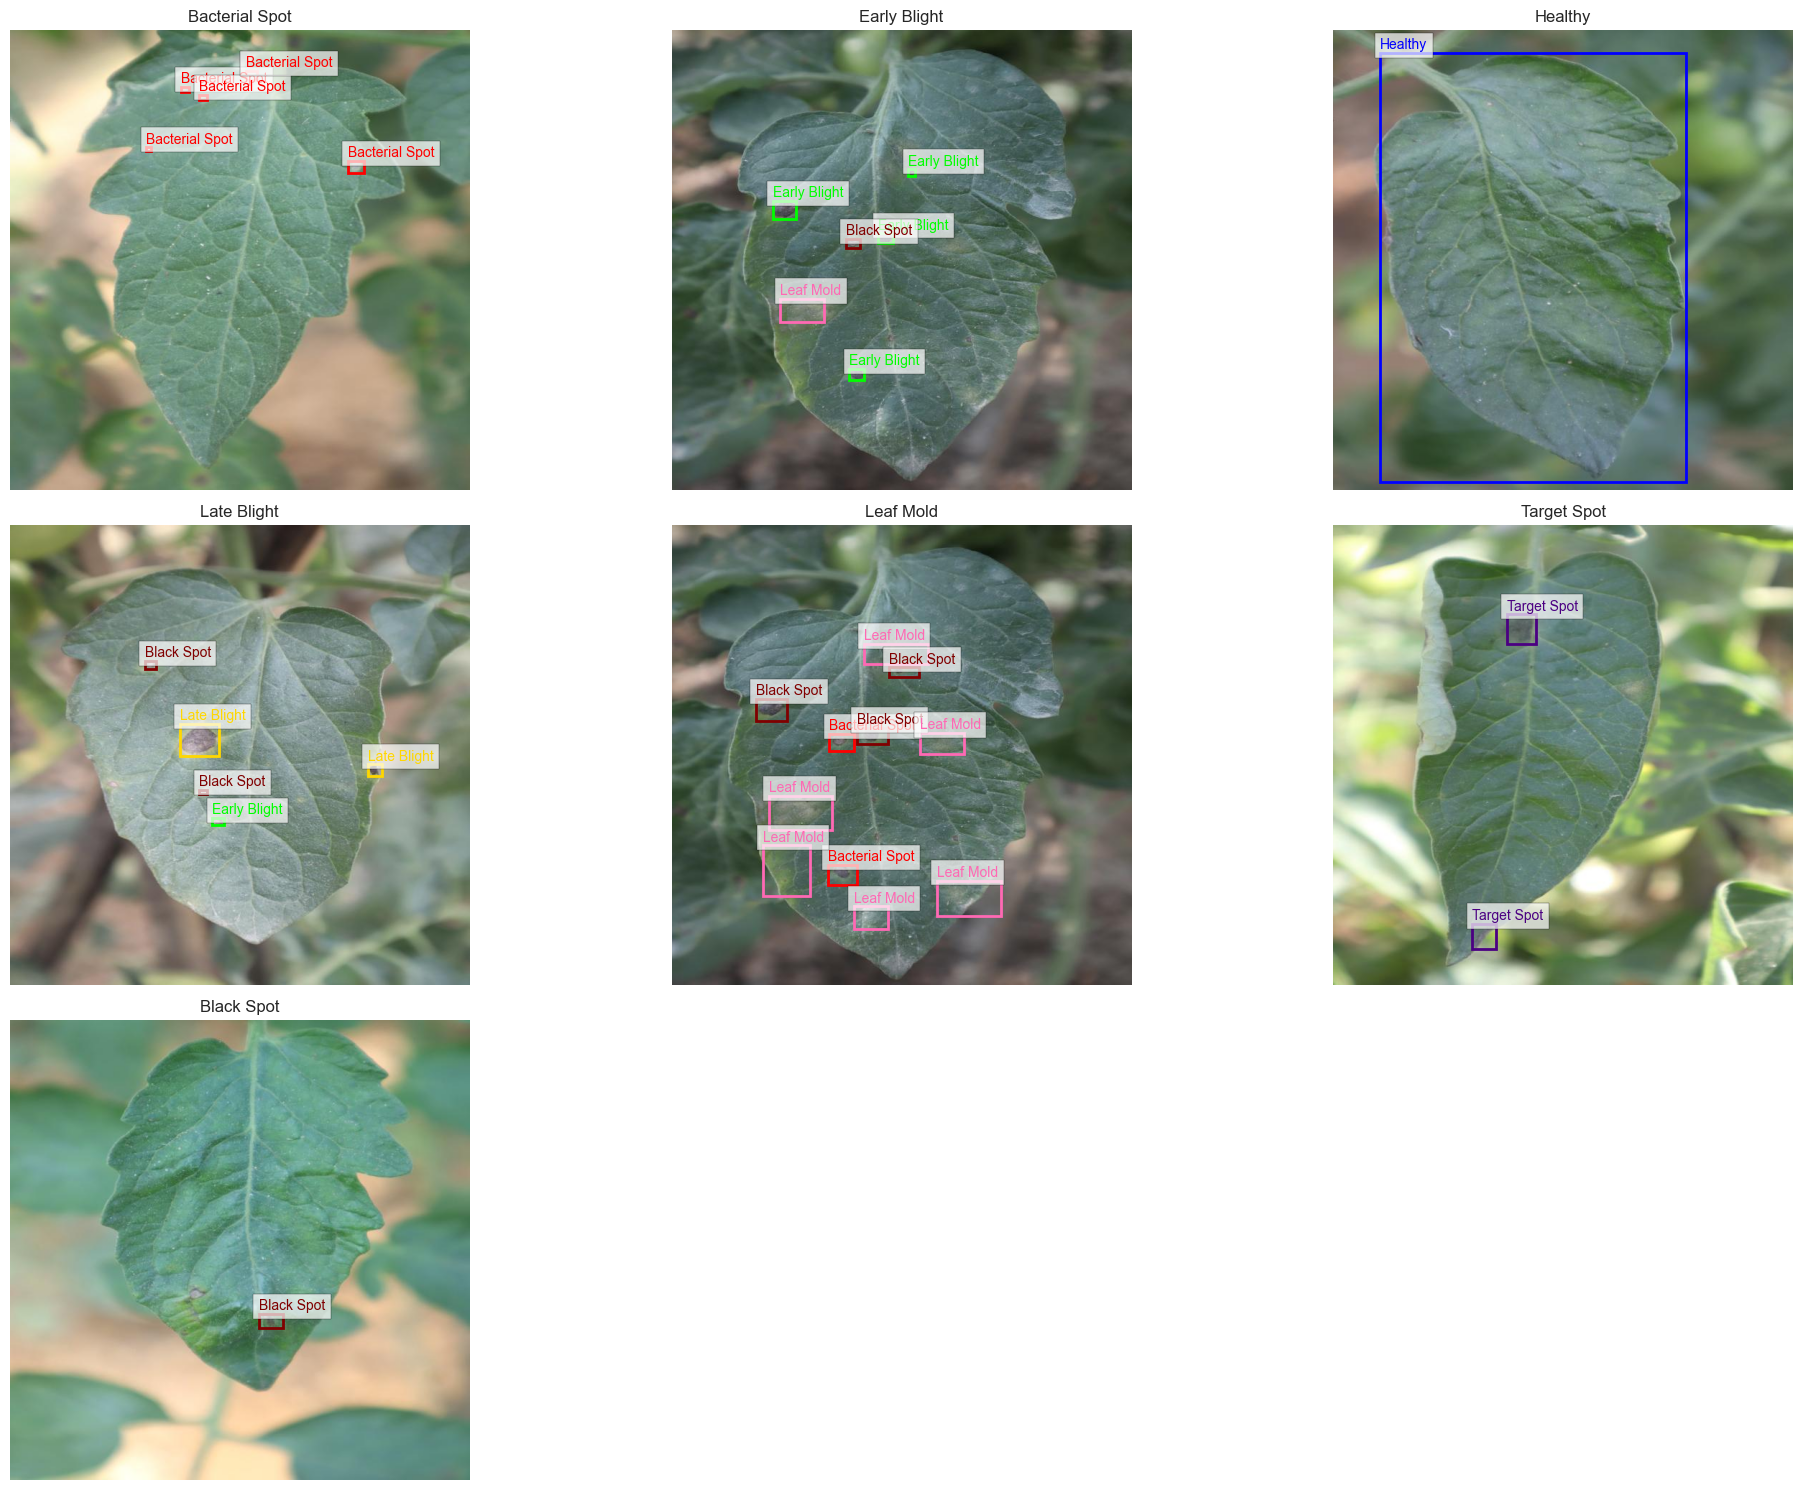

In [ ]:
# Plot one image for each class

examples_per_class = {}

# Search in train folder first, then valid if needed
for split in ['train', 'valid']:
    images_path = DATASET_PATH / split / 'images'
    labels_path = DATASET_PATH / split / 'labels'
    
    if not images_path.exists() or not labels_path.exists():
        print(f"Skipping {split} split - directory not found")
        continue
    
    for label_file in labels_path.glob('*.txt'):
        img_file = images_path / f"{label_file.stem}.jpg"
        
        if not img_file.exists():
            print(f"Warning: Missing image file for {label_file}")
            continue
            
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()
                if not lines:  # Empty file
                    print(f"Warning: Empty label file {label_file}")
                    continue
                    
                line = lines[0].strip()  # Get first line and remove whitespace
                if not line:  # Empty line
                    print(f"Warning: Empty line in {label_file}") # Images without any labels
                    continue
                    
                parts = line.split()
                if not parts:  # No parts after splitting
                    print(f"Warning: Invalid format in {label_file}")
                    continue
                    
                class_id = int(parts[0])
                if class_id not in CLASS_NAMES:
                    print(f"Warning: Invalid class ID {class_id} in {label_file}")
                    continue
                    
                if class_id not in examples_per_class:
                    examples_per_class[class_id] = (img_file, label_file)
        
        except Exception as e:
            print(f"Error processing {label_file}: {str(e)}")
            continue

plt.figure(figsize=(20, 15))
for i, class_id in enumerate(CLASS_NAMES.keys()):
    if class_id in examples_per_class:
        img_path, label_path = examples_per_class[class_id]
        image, boxes = load_yolo_image_with_boxes(img_path, label_path)
        plt.subplot(3, 3, i+1)
        plot_image_with_boxes(image, boxes, title=CLASS_NAMES[class_id])

plt.tight_layout()
plt.show()

# Disease Co-occurrence Analysis

## Understanding Disease Patterns and Relationships

The co-occurrence matrix reveals important patterns about how different tomato leaf diseases appear together in the same images. This analysis helps understand disease relationships and potential diagnostic challenges.

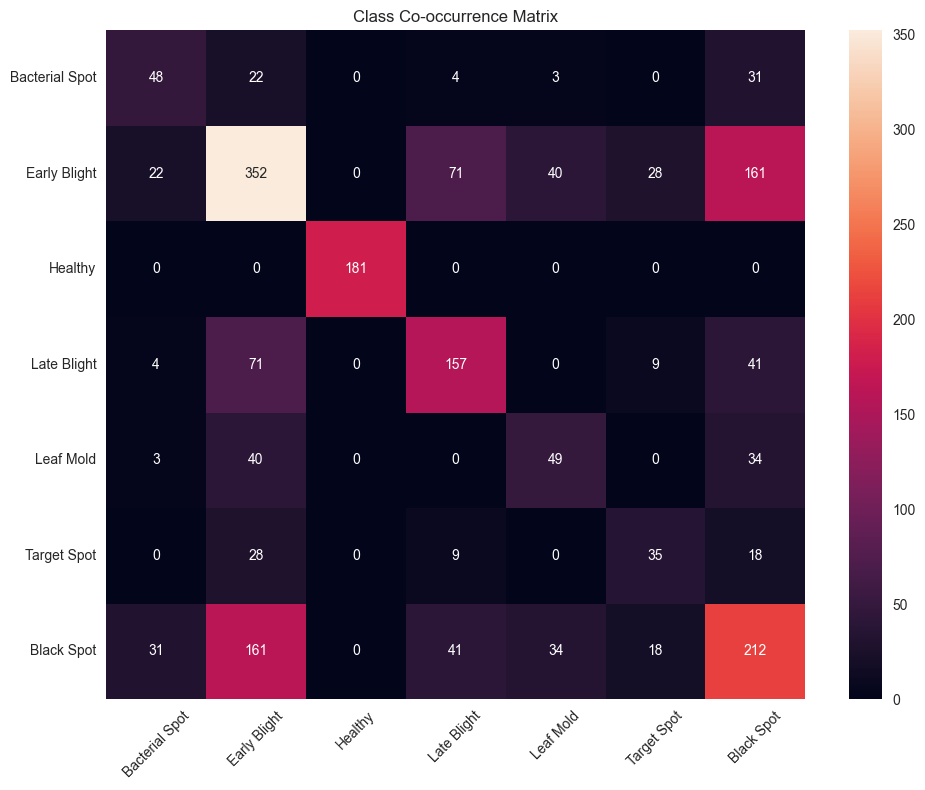

In [ ]:
def analyze_class_cooccurrence(DATASET_PATH):
    """
    Obtain the cooccurrence matrix for classes in the dataset.

    Args:
        DATASET_PATH: Path to the dataset root directory
        
    Returns:
        cooccurrence: Matrix with n columns and rows (n = Number of classes)
    """
    cooccurrence = np.zeros((len(CLASS_NAMES), len(CLASS_NAMES)))
    
    for split in ['train', 'valid']:
        labels_path = DATASET_PATH / split / 'labels'
        if not labels_path.exists():
            continue
            
        for label_file in labels_path.glob('*.txt'):
            classes_in_image = set()
            
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    class_id = int(line.split()[0])
                    classes_in_image.add(class_id)
            
            # Update cooccurrence matrix
            classes_list = list(classes_in_image)
            for i in range(len(classes_list)):
                for j in range(len(classes_list)):
                    cooccurrence[classes_list[i]][classes_list[j]] += 1
    
    return cooccurrence

# Plot co-occurrence matrix
cooccurrence = analyze_class_cooccurrence(DATASET_PATH)

plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence, 
            xticklabels=CLASS_NAMES.values(),
            yticklabels=CLASS_NAMES.values(),
            annot=True, fmt='g')
plt.title('Class Co-occurrence Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Key Findings

### 1. Single Disease Dominance
- **Healthy Leaves (Class 2)**: Shows complete isolation (181 instances) with no co-occurrence with other conditions
- **Early Blight (Class 1)**: Highest individual occurrence (352 instances)
- **Black Spot (Class 6)**: Second highest individual presence (212 instances)

### 2. Significant Co-occurrences

Strong Relationships:
- Early Blight + Black Spot: 161 instances
- Early Blight + Late Blight: 71 instances
- Late Blight + Black Spot: 41 instances

Moderate Relationships:
- Early Blight + Leaf Mold: 40 instances
- Leaf Mold + Black Spot: 34 instances
- Bacterial Spot + Black Spot: 31 instances

### 3. Rare Combinations
- Target Spot shows limited co-occurrence with other diseases
- Bacterial Spot has relatively low co-occurrence rates
- Leaf Mold shows selective co-occurrence patterns

## Implications

### For Disease Management
- Multiple diseases frequently occur together
- Early Blight appears most likely to co-exist with other conditions
- Healthy leaves maintain clear separation from diseased conditions

### For Agricultural Practice
- Early Blight requires particular attention due to high co-occurrence
- Healthy leaf isolation suggests clear visual distinctions
- Multiple disease management strategies may be necessary

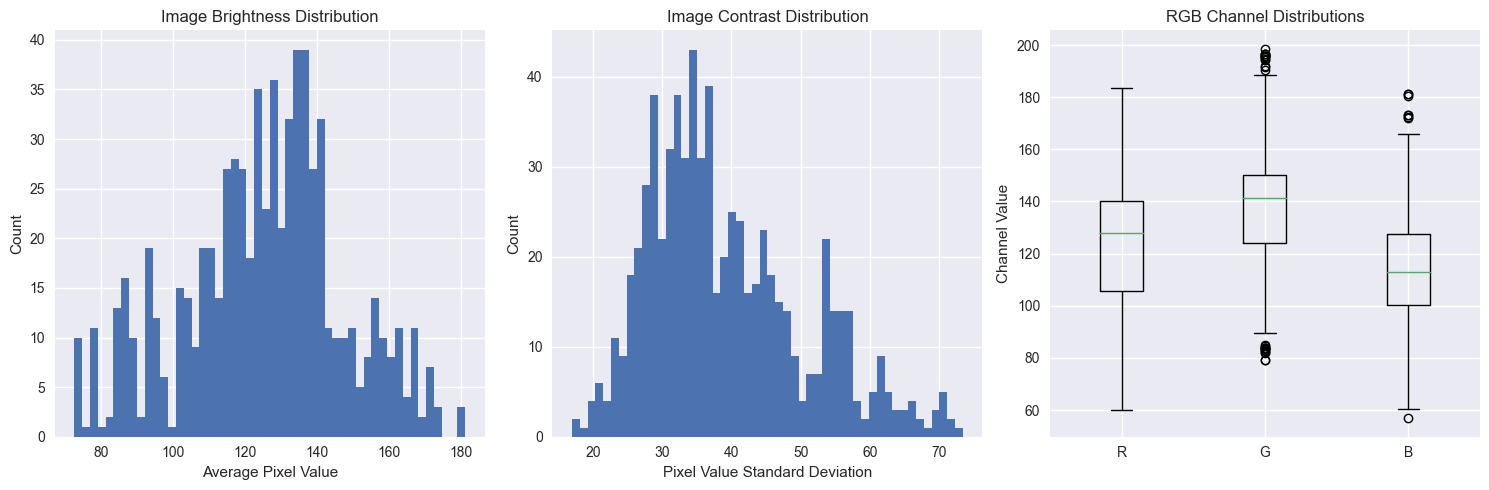

In [ ]:
def analyze_image_characteristics(DATASET_PATH):
    """
    Analyze image characteristics such as brightness, contrast, and color distribution.

    Args:
        DATASET_PATH: path to the dataset root directory
        
    Returns:
        brightness_values: histogram of brightness values
        coontrast_values: histogram of contrast values
        color_distributions: box plot for color distributions in RGB
    """
    
    brightness_values = []
    contrast_values = []
    color_distributions = []
    
    for split in ['train', 'valid']:
        images_path = DATASET_PATH / split / 'images'
        if not images_path.exists():
            continue
            
        for img_file in images_path.glob('*.jpg'):
            img = cv2.imread(str(img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Brightness (average pixel value)
            brightness = np.mean(img)
            brightness_values.append(brightness)
            
            # Contrast (standard deviation of pixel values)
            contrast = np.std(img)
            contrast_values.append(contrast)
            
            # Color distribution
            color_dist = [np.mean(img[:,:,i]) for i in range(3)]
            color_distributions.append(color_dist)
    
    return brightness_values, contrast_values, color_distributions

# Plot image characteristics
brightness, contrast, colors = analyze_image_characteristics(DATASET_PATH)
colors = np.array(colors)

plt.figure(figsize=(15, 5))

# Brightness distribution
plt.subplot(131)
plt.hist(brightness, bins=50)
plt.title('Image Brightness Distribution')
plt.xlabel('Average Pixel Value')
plt.ylabel('Count')

# Contrast distribution
plt.subplot(132)
plt.hist(contrast, bins=50)
plt.title('Image Contrast Distribution')
plt.xlabel('Pixel Value Standard Deviation')
plt.ylabel('Count')

# RGB distribution
plt.subplot(133)
plt.boxplot([colors[:,0], colors[:,1], colors[:,2]], labels=['R', 'G', 'B'])
plt.title('RGB Channel Distributions')
plt.ylabel('Channel Value')

plt.tight_layout()
plt.show()